# 1. Overview

# 2. Data understanding

## 2.1 Data description

## 2.2 Importing Necessary Libraries

In [2]:
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import wordnet
import category_encoders as ce
import pickle
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import warnings

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Suppress all warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Usuario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2.3 Define global variables

In [3]:
pd.set_option('display.max_colwidth', 1000)

## 2.3 Functions

In [4]:
def generalize_tweets(tweet_text):
    """
    Identify if the tweet is about a Google or Apple product, and replace any product-related keywords
    with 'tecproduct'.
    
    Parameters:
    tweet_text (str): The text of the tweet.
    
    Returns:
    str: 'Google' if the tweet mentions a Google product, 'Apple' if the tweet mentions an Apple product,
         'Both' if the tweet mentions both, 'Unknown' if it mentions neither.
    """
    google_keywords = ['google', 'pixel', 'pixels', 'nexus', 'nexuses', 'android', 'androids', 
                       'chromebook', 'chromebooks', 'nest', 'nests', 'stadia', 'stadias']
    apple_keywords = ['apple', 'apples', 'iphone', 'iphones', 'ipad', 'ipads', 'macbook', 
                      'macbooks', 'imac', 'imacs', 'watch', 'watches', 'airpods', 
                      'appstore', 'ios', 'itunes']
    
    # Ensure tweet_text is a string
    if not isinstance(tweet_text, str):
        return 'Unknown'
    
    # Replace "app store" with "appstore" before tokenization
    tweet_text = tweet_text.replace("app store", "appstore")
    
    # Replace any occurrences of google_keywords and apple_keywords with 'tecproduct'
    for keyword in google_keywords + apple_keywords:
        tweet_text = re.sub(rf'\b{keyword}\b', 'tecproduct', tweet_text, flags=re.IGNORECASE)
        
    # Replace @ followed by any text or numbers with 'user'
    tweet_text = re.sub(r'@\w+', 'user', tweet_text)
    
    # Remove # in front of tecproduct if there is
    tweet_text = re.sub(r'#tecproduct', 'tecproduct', tweet_text)
    
    # Replace # followed by any text or numbers with 'trend'
    tweet_text = re.sub(r'#\w+', 'trend', tweet_text)
    
    # Remove URLs
    tweet_text = re.sub(r'http\S+|www\S+|https\S+', 'urls', tweet_text, flags=re.MULTILINE)
    
    # Rename 1g, 2g, 3g, 4g, 5g, 6g, to 'monetwork'
    tweet_text = re.sub(r'\dg', 'monetwork', tweet_text)
    
    return tweet_text


In [5]:
def preprocess_product_mention(df):
    df['product_mention'] = df['product_mention'].astype(str)
    return df

# 3. Code

## 3.1 Import the database

In [6]:
# Load and prepare data
df = pd.read_csv('df_prueba.csv')

## 3.2 Highlighting tech products 

Let's make the tweets lowercase

In [7]:
df['tweet_text'] = df['tweet_text'].str.lower()

df.head()

,tweet_text,emotion_type,product_mention
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Not Positive emotion,Apple
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,Apple
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,Apple
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Not Positive emotion,Apple
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,Google


We have decided to rename all the technical products in the tweet_text column to a general name called tecproduct. As well as substituting all tags in a tweet with a generic name called User, and the # for another generic name called trend. Lastly, we have also replace all urls with a generic name called url. In this way, we will be able to have a more generalized tweet. 

In [8]:
df['tweet_text'] = df['tweet_text'].map(generalize_tweets)

In [9]:
df.head()

,tweet_text,emotion_type,product_mention
0,".user i have a monetwork tecproduct. after 3 hrs tweeting at trend, it was dead! i need to upgrade. plugin stations at trend.",Not Positive emotion,Apple
1,"user know about user ? awesome tecproduct/tecproduct app that you'll likely appreciate for its design. also, they're giving free ts at trend",Positive emotion,Apple
2,user can not wait for tecproduct 2 also. they should sale them down at trend.,Positive emotion,Apple
3,user i hope this year's festival isn't as crashy as this year's tecproduct app. trend,Not Positive emotion,Apple
4,"user great stuff on fri trend: marissa mayer (tecproduct), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,Google


## 3.3 Text cleaning

### 3.3.1 Stop Words

Let's now proceed to eliminate the stopwords

In [10]:
stopwords_to_remove = stopwords.words('english')

df['tweet_text'] = df['tweet_text'].map(lambda x: ' '.join([word for word in x.split() if word not in stopwords_to_remove]))

df.head()

,tweet_text,emotion_type,product_mention
0,".user monetwork tecproduct. 3 hrs tweeting trend, dead! need upgrade. plugin stations trend.",Not Positive emotion,Apple
1,"user know user ? awesome tecproduct/tecproduct app likely appreciate design. also, they're giving free ts trend",Positive emotion,Apple
2,user wait tecproduct 2 also. sale trend.,Positive emotion,Apple
3,user hope year's festival crashy year's tecproduct app. trend,Not Positive emotion,Apple
4,"user great stuff fri trend: marissa mayer (tecproduct), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,Google


We will now proceed to remove strange characters and punctuation

In [11]:
# Remove strange characters and punctuation
strange_chars = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#Ûªåçûïòóêâîô¼¾½±°¤¦¬áàâäãåéèêëíìîïóòôöõúùûüýÿđøñìùđūöý'

df['tweet_text'] = df['tweet_text'].map(lambda x: x.translate(str.maketrans(strange_chars, ' ' * len(strange_chars))))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct 3 hrs tweeting trend dead need upgrade plugin stations trend,Not Positive emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free ts trend,Positive emotion,Apple
2,user wait tecproduct 2 also sale trend,Positive emotion,Apple
3,user hope year s festival crashy year s tecproduct app trend,Not Positive emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim o reilly tech books conferences amp matt mullenweg wordpress,Positive emotion,Google


Now we shall proceed to eliminate numbers

In [12]:
# Remove numbers
df['tweet_text'] = df['tweet_text'].map(lambda x: re.sub(r'\d+', '', x))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct hrs tweeting trend dead need upgrade plugin stations trend,Not Positive emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free ts trend,Positive emotion,Apple
2,user wait tecproduct also sale trend,Positive emotion,Apple
3,user hope year s festival crashy year s tecproduct app trend,Not Positive emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim o reilly tech books conferences amp matt mullenweg wordpress,Positive emotion,Google


We are going to eliminate letters that are on their own in each individual tweet

In [13]:
df['tweet_text'] = df['tweet_text'].map(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct hrs tweeting trend dead need upgrade plugin stations trend,Not Positive emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free ts trend,Positive emotion,Apple
2,user wait tecproduct also sale trend,Positive emotion,Apple
3,user hope year festival crashy year tecproduct app trend,Not Positive emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim reilly tech books conferences amp matt mullenweg wordpress,Positive emotion,Google


## 3.4 Lematization

In [ ]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize each word in tweet_text
df['tweet_text'] = df['tweet_text'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

df.head()

## 3.5 Tokenize

In [15]:
# Tokenize the tweet_text
df['tweet_text_tokenized'] = df['tweet_text'].map(lambda x: word_tokenize(x))

df.head()

,tweet_text,emotion_type,product_mention,tweet_text_tokenized
0,user monetwork tecproduct hr tweeting trend dead need upgrade plugin station trend,Not Positive emotion,Apple,"[user, monetwork, tecproduct, hr, tweeting, trend, dead, need, upgrade, plugin, station, trend]"
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free t trend,Positive emotion,Apple,"[user, know, user, awesome, tecproduct, tecproduct, app, likely, appreciate, design, also, they, re, giving, free, t, trend]"
2,user wait tecproduct also sale trend,Positive emotion,Apple,"[user, wait, tecproduct, also, sale, trend]"
3,user hope year festival crashy year tecproduct app trend,Not Positive emotion,Apple,"[user, hope, year, festival, crashy, year, tecproduct, app, trend]"
4,user great stuff fri trend marissa mayer tecproduct tim reilly tech book conference amp matt mullenweg wordpress,Positive emotion,Google,"[user, great, stuff, fri, trend, marissa, mayer, tecproduct, tim, reilly, tech, book, conference, amp, matt, mullenweg, wordpress]"


## 3.6 Train test split

Let's first define our variables

In [16]:
y = df['emotion_type']
X = df.drop(['emotion_type'], axis=1)

We are going to transform the variable y to numeric. Because all models need their target to be numeric. We will use the LabelEncoder.

In [17]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder and transform the 'emotion_type' column
df['emotion_type_encoded'] = label_encoder.fit_transform(df['emotion_type'])

# The result is a new column 'emotion_type_encoded' with numeric values
y = df['emotion_type_encoded']

In [18]:
# X is the feature set and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

Let's compare the shapes of y_test and y_train to see if they're somewhat similar

In [19]:
y_test.value_counts(normalize=True)

0    0.655877
1    0.344123
Name: emotion_type_encoded, dtype: float64

In [20]:
y_train.value_counts(normalize=True)

0    0.643355
1    0.356645
Name: emotion_type_encoded, dtype: float64

Let's see a description of the distributions

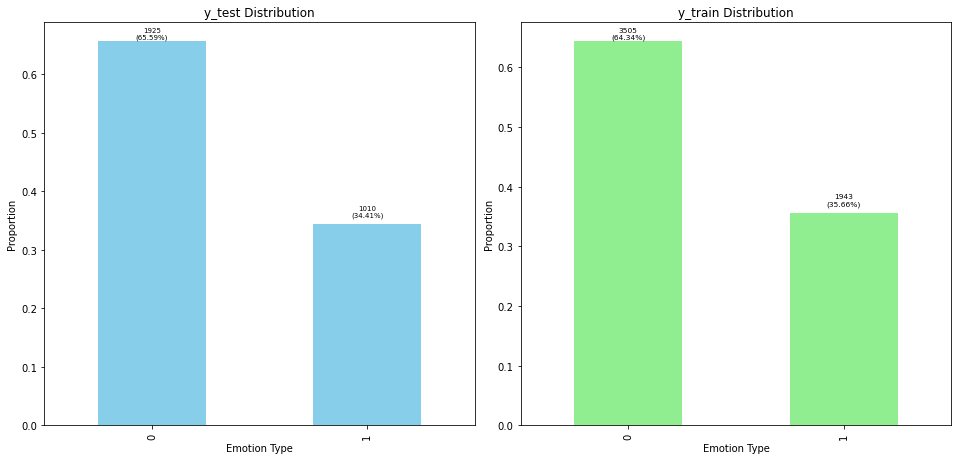

In [21]:
# Create a larger figure
plt.figure(figsize=(14, 7))

# y_test Distribution
plt.subplot(1, 2, 1)
y_test_counts = y_test.value_counts(normalize=True)
y_test_abs_counts = y_test.value_counts()

y_test_counts.plot(kind='bar', color='skyblue')
plt.title('y_test Distribution')
plt.xlabel('Emotion Type')
plt.ylabel('Proportion')

for i, (count, pct) in enumerate(zip(y_test_abs_counts, y_test_counts)):
    vertical_position = pct + 0.002 if pct > 0.5 else pct + 0.01  # Small offset for larger bars
    plt.text(i, vertical_position, f'{count}\n({pct:.2%})', ha='center', va='bottom', fontsize=7)

# y_train Distribution
plt.subplot(1, 2, 2)
y_train_counts = y_train.value_counts(normalize=True)
y_train_abs_counts = y_train.value_counts()

y_train_counts.plot(kind='bar', color='lightgreen')
plt.title('y_train Distribution')
plt.xlabel('Emotion Type')
plt.ylabel('Proportion')

for i, (count, pct) in enumerate(zip(y_train_abs_counts, y_train_counts)):
    vertical_position = pct + 0.002 if pct > 0.5 else pct + 0.01  # Small offset for larger bars
    plt.text(i, vertical_position, f'{count}\n({pct:.2%})', ha='center', va='bottom', fontsize=7.5)

# Adjust layout to make more space around the plots
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.show()


## 3.7 TFIDF

Before starting the procedure of vectorizing our corpus with tfidf, we want to use the a descriptive chart with the cumulative relative frequency of the words in the corpus so we can know the best threshold to set in the vectorizing process.

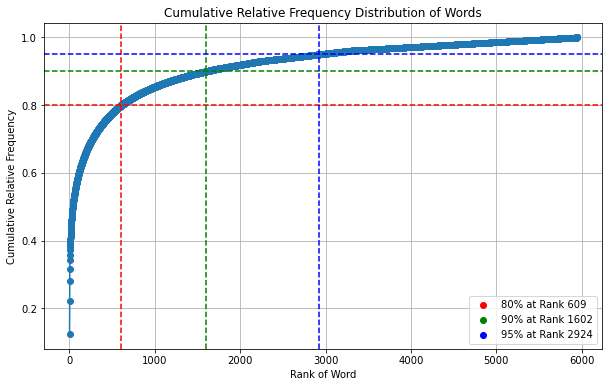

In [22]:
# Flatten the list of lists into a single list
corpus = [word for sublist in X_train['tweet_text_tokenized'] for word in sublist]  

# Count the frequency of each word
word_freq = Counter(corpus)

# Convert the word frequency to a pandas DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Calculate the cumulative frequency and cumulative relative frequency
word_freq_df['Cumulative Frequency'] = word_freq_df['Frequency'].cumsum()
word_freq_df['Cumulative Relative Frequency'] = word_freq_df['Cumulative Frequency'] / word_freq_df['Frequency'].sum()

# Find the rank where the cumulative relative frequency reaches 80%
rank_80_percent = word_freq_df[word_freq_df['Cumulative Relative Frequency'] >= 0.8].index[0] + 1
cumulative_80_percent = word_freq_df.loc[rank_80_percent - 1, 'Cumulative Relative Frequency']

# Find the rank where the cumulative relative frequency reaches 90%
rank_90_percent = word_freq_df[word_freq_df['Cumulative Relative Frequency'] >= 0.9].index[0] + 1
cumulative_90_percent = word_freq_df.loc[rank_90_percent - 1, 'Cumulative Relative Frequency']

# Find the rank where the cumulative relative frequency reaches 95%
rank_95_percent = word_freq_df[word_freq_df['Cumulative Relative Frequency'] >= 0.95].index[0] + 1
cumulative_95_percent = word_freq_df.loc[rank_95_percent - 1, 'Cumulative Relative Frequency']

# Plot the cumulative relative frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(word_freq_df) + 1), word_freq_df['Cumulative Relative Frequency'], marker='o')
plt.title('Cumulative Relative Frequency Distribution of Words')
plt.xlabel('Rank of Word')
plt.ylabel('Cumulative Relative Frequency')

# Mark the point where the cumulative relative frequency reaches 80%
plt.scatter(rank_80_percent, cumulative_80_percent, color='red', label=f'80% at Rank {rank_80_percent}')
plt.axvline(x=rank_80_percent, color='red', linestyle='--')
plt.axhline(y=cumulative_80_percent, color='red', linestyle='--')

# Mark the point where the cumulative relative frequency reaches 90%
plt.scatter(rank_90_percent, cumulative_90_percent, color='green', label=f'90% at Rank {rank_90_percent}')
plt.axvline(x=rank_90_percent, color='green', linestyle='--')
plt.axhline(y=cumulative_90_percent, color='green', linestyle='--')

# Mark the point where the cumulative relative frequency reaches 95%
plt.scatter(rank_95_percent, cumulative_95_percent, color='blue', label=f'95% at Rank {rank_95_percent}')
plt.axvline(x=rank_95_percent, color='blue', linestyle='--')
plt.axhline(y=cumulative_95_percent, color='blue', linestyle='--')

plt.legend()
plt.grid(True)
plt.show()


As we can see, by only using 615 words, we have 80% of our entire corpus. And using 1598 words, we have a 90% of our entire corpus. With that in mind, in the past, we thought it made sense to use max_features of 80% in the vectorization process given that we wouldn't win much if we considered 1598 words as it only a gain of 10% more.

However, the results were not convincing and so we decided to eliminate the threshold and to get all the words. In this way we mitigated overfitting and improved the confusion matrix that is shown in notebook 03_modelling.

Knowing our max_features number, let's proceed and do the calculations of tfidf

In [23]:
# Step 1: Initialize the TfidfVectorizer with the desired max_features parameter
tfidf_vectorizer = TfidfVectorizer()

# Step 2: Fit the vectorizer on the tweet texts and transform the data into TF-IDF features
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train['tweet_text'])

# Step 3: Convert the TF-IDF matrix to a DataFrame for easier interpretation
# The DataFrame will have words as columns and documents as rows, with each cell containing the TF-IDF score
tfidf_df_train = pd.DataFrame(tfidf_matrix_train.toarray(), 
                              columns=tfidf_vectorizer.get_feature_names_out(),
                              index=X_train.index) # Keep the original index

tfidf_df_train

,aapl,aaron,ab,abacus,abba,abc,aber,ability,able,abnormal,...,zimride,zing,zite,zms,zombie,zomg,zone,zoom,zynga,zzzs
8236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's apply the tf-idf on the X_test

In [ ]:
# Step 1: Transform the tweet texts on the X_test with the vectorizer and transform the data into TF-IDF features
tfidf_matrix_test = tfidf_vectorizer.transform(X_test['tweet_text'])

# Step 2: Convert the TF-IDF matrix to a DataFrame for easier interpretation
# The DataFrame will have words as columns and documents as rows, with each cell containing the TF-IDF score
tfidf_df_test = pd.DataFrame(tfidf_matrix_test.toarray(), 
                             columns=tfidf_vectorizer.get_feature_names_out(), 
                             index=X_test.index) # Keep the original index)

tfidf_df_test

We are first going to merge the product_mention and the y_train, y_test columns to tfidf_df_train and tfidf_df_test separately.

In [ ]:
# For tfidf_df_train. Let's join tfidf_df_train and X_train by index
df_train = X_train[['product_mention']].join(tfidf_df_train)

# Let's now join y_train with df_train
df_train = df_train.join(y_train)

df_train

In [ ]:
# For tfidf_df_test. Let's join tfidf_df_test and X_test by index
df_test = X_test[['product_mention']].join(tfidf_df_test)

# Let's now join y_test with df_test
df_test = df_test.join(y_test)

df_test

We shall now proceed to save the pickle of the tfidf_vectorizer

In [ ]:
# Save the tfidf_vectorizer in a pickle folder called pickle_objects
with open('pickle_objects/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

Let's do a one hot encoder on the product_mention column of df_train

In [ ]:
# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the 'product_mention' column
encoded_features = onehot_encoder.fit_transform(df_train[['product_mention']])

# Convert the array back to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(['product_mention']))

# Concatenate the encoded columns back to the original DataFrame
df_train_encoded = pd.concat([df_train.reset_index(drop=True), encoded_df], axis=1)

# Drop the 'product_mention' column
df_train_encoded.drop('product_mention', axis=1, inplace=True)

# Display the DataFrame with the encoded columns
df_train_encoded.head()

Let's do the One Hot Encoder for X_test

In [ ]:
# Transform the 'product_mention' column
encoded_features = onehot_encoder.transform(df_test[['product_mention']])

# Convert the array back to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(['product_mention']))

# Concatenate the encoded columns back to the original DataFrame
df_test_encoded = pd.concat([df_test.reset_index(drop=True), encoded_df], axis=1)

# Drop the 'product_mention' column
df_test_encoded.drop('product_mention', axis=1, inplace=True)

# Display the DataFrame with the encoded columns
df_test_encoded.head()

Let's save the pickle for the One Hot Encoder

In [ ]:
# Save the ohe in a pickle folder called pickle_objects
with open('pickle_objects/ohe.pkl', 'wb') as file:
    pickle.dump(onehot_encoder, file)

# 4. Export to csv

In [ ]:
# Save df_train_encoded to a CSV file
df_train_encoded.to_csv('data/train_processed_prueba.csv', index=False)
# The index=False argument ensures that the DataFrame index is not written to the file

# Save df_test_encoded to a CSV file
df_test_encoded.to_csv('data/test_processed_prueba.csv', index=False)